# Libraries

In [ ]:
#=========== ایمپورت کردن کتابخانه ها===========
from google.colab import drive
import pandas as pd
import json
from sklearn.utils import resample
import matplotlib.pyplot as plt

# Loading Data

In [2]:
 #=========== اتصال Google Drive به محیط اجرایی Colab برای دسترسی به فایل‌ها ===========
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#=========== خواندن فایل اصلی دیتا ست و دیدن دسته بندی ها ===========

file_path = '/content/drive/MyDrive/Farsi_Sports_Dataset/persian-news-dataset/csv_output.csv'
df = pd.read_csv(file_path)

print(df['service'].unique())
df.head()

['استانها' 'بین الملل' 'فرهنگ' 'ورزشی' 'تعلیم و تربیت' 'سیاسی'
 'آرشیو اخبار' 'اقتصادی' 'جامعه' 'هنر و رسانه' 'دفاتر منطقه ای'
 'علم و پیشرفت' 'مجله فارس پلاس' 'تفریح و نشاط' 'یادداشت' 'افکارسنجی'
 'زندگی']


,id,title,short_link,service,subgroup,abstract,body,tags,published_datetime,agency_name
0,1,پیروزی قاطع مس سونگون /نارنجی‌پوشان 6 تایی کردند,http://fna.ir/f1v1mt,استانها,آذربایجان شرقی,تیم مس سونگون برابر مهمان خود به برتری پرگل دس...,به گزارش خبرگزاری فارس از تبریز، در هفته چهارم...,"لیگ برتر, مس, تبریز, اصفهان, مس سونگون, ورزقان...",2021-01-01 11:53:52,FarsNews
1,2,پخت و توزیع آش نذری به‌مناسبت سالگرد شهادت سرد...,http://fna.ir/f1v1mk,استانها,مازندران,پخت آش نذری در مرکز مازندران توسط یکی از عشاق ...,خبرگزاری فارس مازندران ـ نذری پزون یکی از سنت...,"مازندران, حاج قاسم, شهید",2021-01-01 11:51:50,FarsNews
2,3,ترامپ از تجمع بزرگ روز چهارشنبه طرفدارانش در و...,http://fna.ir/f1v1mv,بین الملل,آمریکا، اروپا,رئیس جمهور آمریکا در پیامی در توییتر از تجمع ب...,به گزارش گروه بین‌الملل خبرگزاری فارس، «دونالد...,"واشنگتن, توییتر, آمریکا, مایک پنس",2021-01-01 11:51:41,FarsNews
3,4,پیام تسلیت نماینده ولی‌فقیه در قرارگاه ثارالله...,http://fna.ir/f1v1mh,فرهنگ,حج و زیارت و وقف,نماینده ولی فقیه در قرارگاه ثارالله در پی پیام...,به گزارش خبرگزاری فارس، آیت الله محمدتقی مصباح...,"علی شیرازی, نماینده سابق ولی فقیه در نیروی قدس...",2021-01-01 11:50:42,FarsNews
4,5,بایرن با موسیالا قرارداد حرفه ای منعقد می کند,http://fna.ir/f1v1mq,ورزشی,فوتبال جهان,باشگاه فوتبال بایرن مونیخ با پدیده کم سن و سال...,به گزارش خبرگزاری فارس، «جمال موسیالا» در بازی...,"بایرن مونیخ, فوتبال, بایرن, بوندس‌لیگا",2021-01-01 11:50:00,FarsNews


# Data Prepration

In [10]:

#=========== تنظیمات اصلی پروژه ===========
SELECTED_CLASSES = ['ورزشی', 'اقتصادی', 'فرهنگ', 'تفریح و نشاط']
SAMPLES_PER_CLASS = 1200
LLM_ZERO_SHOT_COUNT = 100
LLM_FEW_SHOT_SUPPORT = 8
LLM_FEW_SHOT_QUERY = 92


VOTING_LARGE_COUNT = 1000
VOTING_SMALL_COUNT = 300

#=========== بارگذاری و پاکسازی اولیه داده‌ها ===========
file_path = '/content/drive/MyDrive/Farsi_Sports_Dataset/persian-news-dataset/csv_output.csv'
df = pd.read_csv(file_path)

if 'id' not in df.columns:
    df = df.reset_index().rename(columns={'index': 'id'})

df.dropna(subset=['title', 'abstract', 'body', 'service'], inplace=True)

# حذف نمونه‌های تکراری بر اساس ستون‌های مهم برای RAG
df["content_for_dedup"] = df["title"].astype(str) + df["abstract"].astype(str) + df["body"].astype(str) + df["tags"].astype(str) + df["agency_name"].astype(str)
df.drop_duplicates(subset=["content_for_dedup"], inplace=True)
df.drop(columns=["content_for_dedup"], inplace=True)

balanced_dfs = []
for category in SELECTED_CLASSES:
    class_subset = df[df['service'] == category]
    sampled = resample(class_subset, n_samples=SAMPLES_PER_CLASS, random_state=42)
    balanced_dfs.append(sampled)

balanced_df = pd.concat(balanced_dfs).reset_index(drop=True)
balanced_df = balanced_df.rename(columns={'service': 'label'})
balanced_df['id'] = balanced_df['id'].astype(str)

all_labeled_df = balanced_df.copy()

save_path = "/content/drive/MyDrive/Farsi_Sports_Dataset/Final/"

def save_json(df, filename):
    full_path = save_path + filename

    if "zero_shot" in filename or "few_shot" in filename or "voting" in filename:
        records = []
        for _, row in df.iterrows():
            records.append({
                "id": row["id"],
                "title": row.get("title", ""),
                "abstract": row.get("abstract", ""),
                "body": row.get("body", ""),
                "label": row["label"],
                "predicted_label": "",
                "prompt_used": ""
            })
    else:
        records = df.to_dict(orient="records")

    with open(full_path, "w", encoding="utf-8") as f:
        json.dump(records, f, ensure_ascii=False, indent=2)

    print(f"✅ فایل ذخیره شد: {full_path}")

# ذخیره دیتاست کامل
save_json(all_labeled_df[['id', 'title', 'abstract', 'body', 'label']], "all_labeled_data.json")

#=========== آماده‌سازی داده‌های LLM ==========

llm_zero_shot_df = all_labeled_df.sample(n=LLM_ZERO_SHOT_COUNT, random_state=1)
llm_zero_shot_df_export = llm_zero_shot_df.copy()

remaining_df = all_labeled_df.drop(llm_zero_shot_df.index).reset_index(drop=True)

llm_few_shot_support_df = remaining_df.sample(n=LLM_FEW_SHOT_SUPPORT, random_state=2)
llm_few_shot_support_df_export = llm_few_shot_support_df.copy()

remaining_df = remaining_df.drop(llm_few_shot_support_df.index).reset_index(drop=True)

llm_few_shot_query_df = remaining_df.sample(n=LLM_FEW_SHOT_QUERY, random_state=3)
llm_few_shot_query_df_export = llm_few_shot_query_df.copy()

llm_few_shot_combined = pd.concat([
    llm_few_shot_support_df_export,
    llm_few_shot_query_df_export
]).reset_index(drop=True)

#=========== اضافه کردن داده‌های Voting Classifier ==========

# ستون‌های مهم برای RAG ترکیب شده در text
def combine_text(row):
    parts = []
    if pd.notna(row['title']):
        parts.append("عنوان: " + row['title'])
    if pd.notna(row['abstract']):
        parts.append("خلاصه: " + row['abstract'])
    if pd.notna(row['body']):
        parts.append("متن: " + row['body'])
    if pd.notna(row.get('tags', None)):
        parts.append("برچسب‌ها: " + str(row['tags']))
    if pd.notna(row.get('agency_name', None)):
        parts.append("منبع: " + str(row['agency_name']))
    return "\n".join(parts)

all_labeled_df['text'] = all_labeled_df.apply(combine_text, axis=1)

# نمونه بزرگ‌تر برای Voting
voting_large_df = all_labeled_df.sample(n=VOTING_LARGE_COUNT, random_state=10).reset_index(drop=True)

# نمونه کوچکتر برای Voting (از باقی‌مانده)
remaining_for_voting = all_labeled_df.drop(voting_large_df.index).reset_index(drop=True)
voting_small_df = remaining_for_voting.sample(n=VOTING_SMALL_COUNT, random_state=20).reset_index(drop=True)

# تابع ذخیره JSON برای Voting (با ساختار مشابه zero-shot و few-shot)
def save_json_voting(df, filename):
    full_path = save_path + filename
    records = []
    for _, row in df.iterrows():
        records.append({
            "id": row["id"],
            "text": row["text"],
            "label": row["label"],
            "predicted_label": "",
            "prompt_used": ""
        })
    with open(full_path, "w", encoding="utf-8") as f:
        json.dump(records, f, ensure_ascii=False, indent=2)
    print(f"✅ فایل ذخیره شد: {full_path}")

# ذخیره فایل‌های LLM
save_json(llm_zero_shot_df_export[['id', 'title', 'abstract', 'body', 'label']], "llm_zero_shot.json")
save_json(llm_few_shot_combined[['id', 'title', 'abstract', 'body', 'label']], "llm_few_shot.json")

# ذخیره فایل‌های Voting
save_json_voting(voting_large_df, "voting_classifier_large.json")
save_json_voting(voting_small_df, "voting_classifier_small.json")

print("✅ تمام فایل‌ها با موفقیت ذخیره شدند.")

✅ فایل ذخیره شد: /content/drive/MyDrive/Farsi_Sports_Dataset/Final/all_labeled_data.json
✅ فایل ذخیره شد: /content/drive/MyDrive/Farsi_Sports_Dataset/Final/llm_zero_shot.json
✅ فایل ذخیره شد: /content/drive/MyDrive/Farsi_Sports_Dataset/Final/llm_few_shot.json
✅ فایل ذخیره شد: /content/drive/MyDrive/Farsi_Sports_Dataset/Final/voting_classifier_large.json
✅ فایل ذخیره شد: /content/drive/MyDrive/Farsi_Sports_Dataset/Final/voting_classifier_small.json
✅ تمام فایل‌ها با موفقیت ذخیره شدند.


# Data Distribution

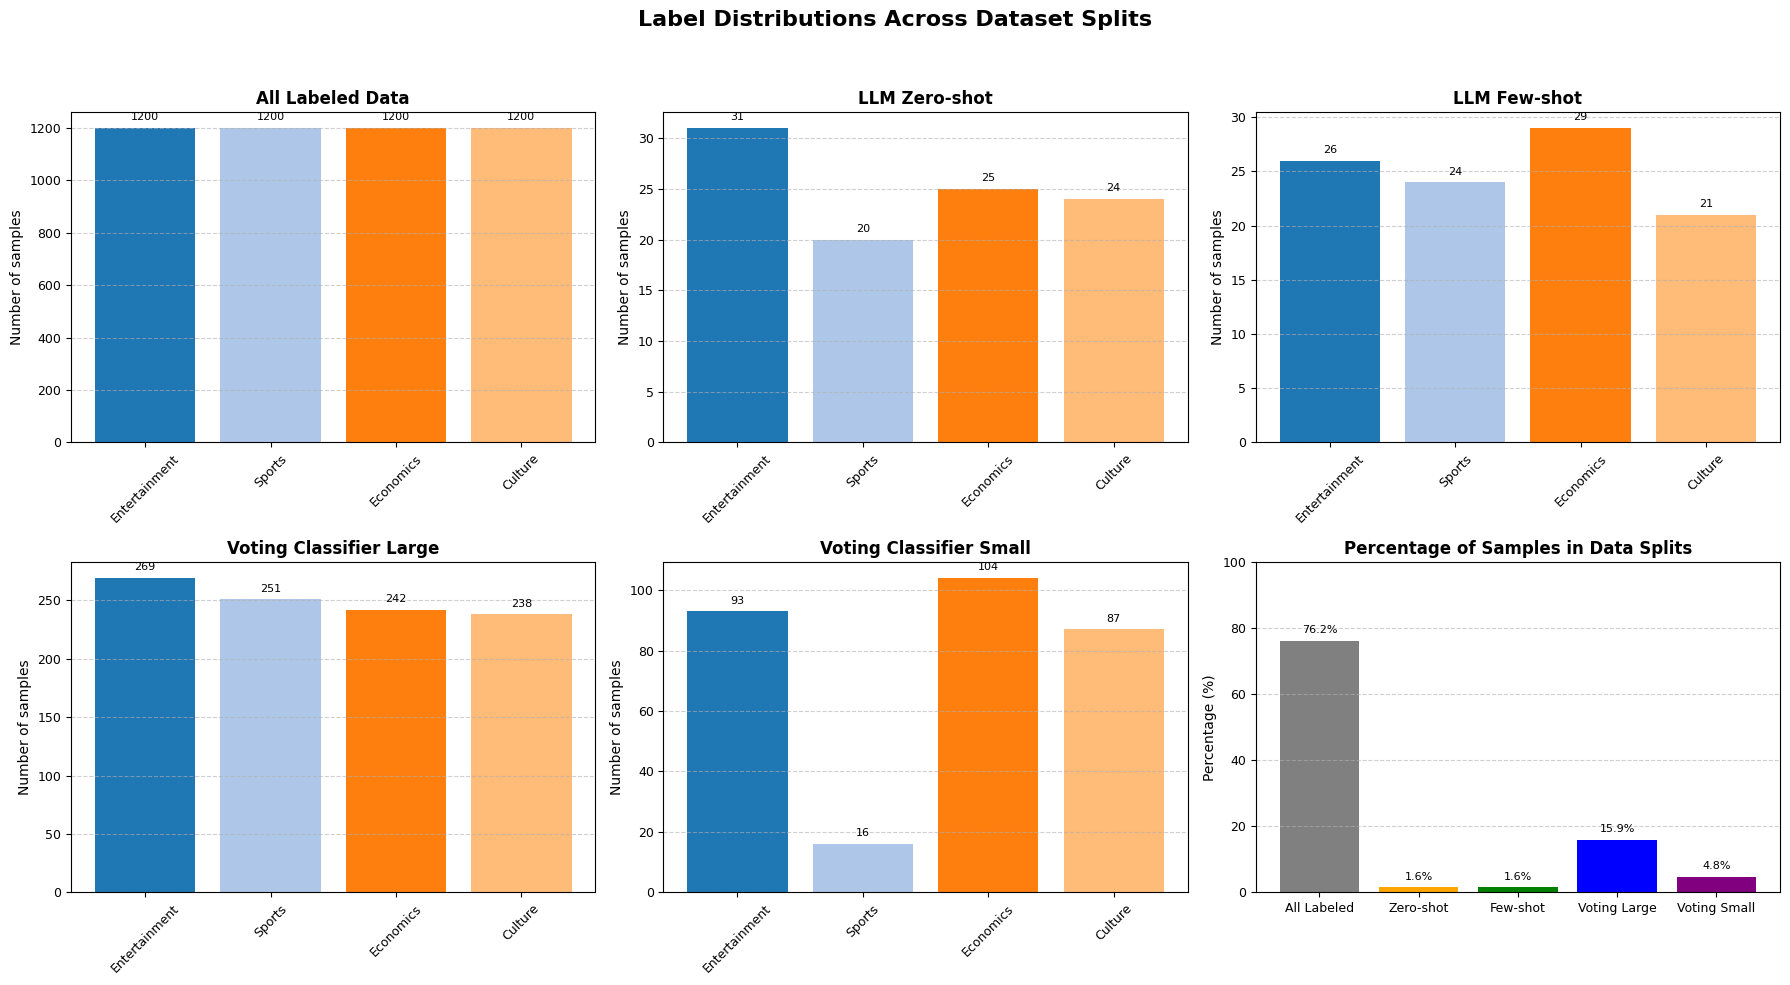

In [5]:

#=========== خواندن فایل های ساخته شده ===========

files = {
    "all_labeled_data": "/content/drive/MyDrive/Farsi_Sports_Dataset/Final/all_labeled_data.json",
    "llm_zero_shot": "/content/drive/MyDrive/Farsi_Sports_Dataset/Final/llm_zero_shot.json",
    "llm_few_shot": "/content/drive/MyDrive/Farsi_Sports_Dataset/Final/llm_few_shot.json",
    "voting_large": "/content/drive/MyDrive/Farsi_Sports_Dataset/Final/voting_classifier_large.json",
    "voting_small": "/content/drive/MyDrive/Farsi_Sports_Dataset/Final/voting_classifier_small.json"
}
#=========== ترجمه دسته بندی ها برای خوانایی بیشتر===========

fa_to_en = {
    'تفریح و نشاط': 'Entertainment',
    'ورزشی': 'Sports',
    'اقتصادی': 'Economics',
    'فرهنگ': 'Culture'
}

def load_labels(file_path, label_key="label"):
    with open(file_path, "r", encoding="utf-8") as f:
        data = json.load(f)
    labels = []
    for item in data:
        label = item.get(label_key, "")
        if label in fa_to_en:
            labels.append(label)
    return labels

def get_label_distribution(labels):
    dist = {}
    for l in labels:
        dist[l] = dist.get(l, 0) + 1
    return dist

def plot_distribution_ax(ax, dist, title):
    # مرتب‌سازی دسته‌ها بر اساس ترتیب fa_to_en
    categories = [k for k in fa_to_en.keys() if k in dist]
    counts = [dist[c] for c in categories]
    en_labels = [fa_to_en[c] for c in categories]

    bars = ax.bar(en_labels, counts, color=plt.cm.tab20.colors[:len(categories)])
    ax.set_title(title, fontsize=12, weight='bold')
    ax.set_ylabel('Number of samples', fontsize=10)
    ax.tick_params(axis='x', rotation=45, labelsize=9)
    ax.tick_params(axis='y', labelsize=9)
    ax.grid(axis='y', linestyle='--', alpha=0.6)

    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 4), textcoords="offset points",
                    ha='center', va='bottom', fontsize=8)

def plot_data_splits_distribution_ax(ax, *dists):
    labels = ['All Labeled', 'Zero-shot', 'Few-shot', 'Voting Large', 'Voting Small']
    totals = [sum(d.values()) for d in dists]
    total_all = sum(totals)
    percentages = [t / total_all * 100 for t in totals]

    bars = ax.bar(labels, percentages, color=['gray', 'orange', 'green', 'blue', 'purple'])
    ax.set_title('Percentage of Samples in Data Splits', fontsize=12, weight='bold')
    ax.set_ylabel('Percentage (%)', fontsize=10)
    ax.tick_params(axis='x', labelsize=9)
    ax.tick_params(axis='y', labelsize=9)
    ax.set_ylim(0, 100)
    ax.grid(axis='y', linestyle='--', alpha=0.6)

    for bar, pct in zip(bars, percentages):
        ax.annotate(f'{pct:.1f}%',
                    xy=(bar.get_x() + bar.get_width()/2, bar.get_height()),
                    xytext=(0, 4), textcoords='offset points',
                    ha='center', va='bottom', fontsize=8)

#=========== بارگذاری لیبل‌ها و توزیع‌ها ===========

all_labeled_labels = load_labels(files["all_labeled_data"])
zero_shot_labels = load_labels(files["llm_zero_shot"])
few_shot_labels = load_labels(files["llm_few_shot"])
voting_large_labels = load_labels(files["voting_large"])
voting_small_labels = load_labels(files["voting_small"])

all_labeled_dist = get_label_distribution(all_labeled_labels)
zero_shot_dist = get_label_distribution(zero_shot_labels)
few_shot_dist = get_label_distribution(few_shot_labels)
voting_large_dist = get_label_distribution(voting_large_labels)
voting_small_dist = get_label_distribution(voting_small_labels)

#==========ایجاد شکل و زیرنمودارها (2 ردیف، 3 ستون)==========
fig, axs = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Label Distributions Across Dataset Splits', fontsize=16, weight='bold')
fig.subplots_adjust(hspace=0.5, wspace=0.4)

# ========== نمودارهای ردیف بالا==========
plot_distribution_ax(axs[0,0], all_labeled_dist, 'All Labeled Data')
plot_distribution_ax(axs[0,1], zero_shot_dist, 'LLM Zero-shot')
plot_distribution_ax(axs[0,2], few_shot_dist, 'LLM Few-shot')

#==========نمودارهای ردیف پایین==========
plot_distribution_ax(axs[1,0], voting_large_dist, 'Voting Classifier Large')
plot_distribution_ax(axs[1,1], voting_small_dist, 'Voting Classifier Small')

#========== نمودار درصد نمونه‌ها در داده‌ها==========
plot_data_splits_distribution_ax(axs[1,2], all_labeled_dist, zero_shot_dist, few_shot_dist, voting_large_dist, voting_small_dist)

plt.tight_layout(rect=[0, 0, 1, 0.95])  # تنظیم فاصله‌ها و جاگذاری عنوان کلی
plt.show()
